<a href="https://colab.research.google.com/github/elgrhy/churnpredictionmodel/blob/main/ChurnPredicts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving digital_banking_data.csv to digital_banking_data.csv
Saving new_customers.csv to new_customers (1).csv


In [6]:
!pip3 install pandas
!pip install -U scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [30]:
!pip3 install matplotlib
!pip3 install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


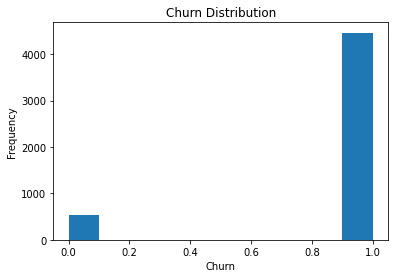

Cross-validation scores: [0.947 1.    1.    1.    0.548]
Mean score: 0.899
Churn risk predictions for new customers: [0 0 0 ... 0 0 0]


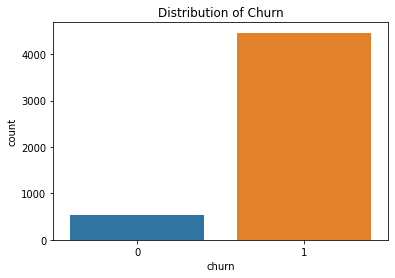

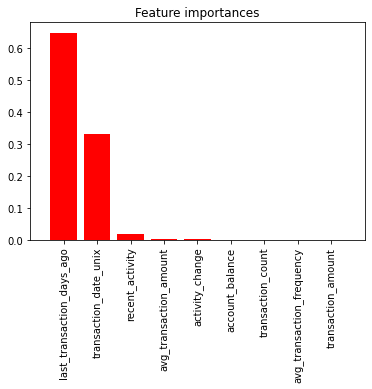

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
digital_data = pd.read_csv('digital_banking_data.csv')

# Preprocess data
digital_data['transaction_date'] = pd.to_datetime(digital_data['transaction_date'])
digital_data['transaction_date_unix'] = digital_data['transaction_date'].apply(lambda x: x.timestamp())
digital_data['transaction_count'] = digital_data['transaction_amount'] / digital_data['account_balance']
digital_data['last_transaction_days_ago'] = (pd.Timestamp('now') - digital_data['transaction_date']).dt.days
digital_data['avg_transaction_amount'] = digital_data.groupby('customer_id')['transaction_amount'].transform('mean')
digital_data['avg_transaction_frequency'] = digital_data.groupby('customer_id')['transaction_date'].transform('count')
digital_data['activity_change'] = digital_data.groupby('customer_id')['transaction_date_unix'].transform(lambda x: x.diff().mean())
digital_data['recent_activity'] = (pd.Timestamp('now') - digital_data.groupby('customer_id')['transaction_date'].transform('max')).dt.days
digital_data['churn'] = ((pd.Timestamp('now') - digital_data['transaction_date']).dt.days > 90).astype(int)

# Visualize the distribution of the target variable
plt.hist(digital_data['churn'])
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Frequency')
plt.show()

# Split data into training and testing sets
X = digital_data.drop(['customer_id', 'churn', 'transaction_date'], axis=1)
y = digital_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define imputer transformer
imputer = SimpleImputer(strategy='mean')

# Define pipeline
pipeline = Pipeline(steps=[('imputer', imputer), ('model', RandomForestClassifier())])

# Define hyperparameters for tuning
param_grid = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Train model with hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate model with cross-validation
scores = cross_val_score(best_model, X, y, cv=5)
print('Cross-validation scores:', scores)
print('Mean score:', scores.mean())

# Use model to predict churn risk for new customers
new_data = pd.read_csv('new_customers.csv')
new_data['transaction_date'] = pd.to_datetime(new_data['transaction_date'])
new_data['transaction_date_unix'] = new_data['transaction_date'].apply(lambda x: x.timestamp())
new_data['transaction_count'] = new_data['transaction_amount'] / new_data['account_balance']
new_data['last_transaction_days_ago'] = (pd.Timestamp('now') - new_data['transaction_date']).dt.days
new_data['avg_transaction_amount'] = new_data.groupby('customer_id')['transaction_amount'].transform('mean')
new_data['avg_transaction_frequency'] = new_data.groupby('customer_id')['transaction_date'].transform('count')
new_data['activity_change'] = new_data.groupby('customer_id')['transaction_date_unix'].transform(lambda x: x.diff().mean())
new_data['recent_activity'] = (pd.Timestamp('now') - new_data.groupby('customer_id')['transaction_date'].transform('max')).dt.days

new_customers_churn_risk = best_model.predict(new_data.drop(['customer_id', 'transaction_date'], axis=1))
print('Churn risk predictions for new customers:', new_customers_churn_risk)

#Visualize distribution of churn
sns.countplot(x='churn', data=digital_data)
plt.title('Distribution of Churn')
plt.show()

#Visualize feature importance
importances = best_model.named_steps['model'].feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

